Author: Kaveh Mahdavi <kavehmahdavi74@yahoo.com>
License: BSD 3 clause
last update: 28/12/2022

# Implementing Custom Layers

The best way is extending the tf.keras.Layer class and implementing:

* **__init__** , where you can do all input-independent initialization
* **build**, where you know the shapes of the input tensors and can do the rest of the initialization
* **call**, where you do the forward computation


In [21]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [44]:
def eval_plot(_history, xy=[], titel=None):
    """ Plots the model history evaluation

    :param _history (pandas): Includes the evaluation data
    :param xy (list): Includes the name of the x and y features
    :param titel (str): The plot name
    """
    plt.plot(_history.history[xy[0]])
    plt.plot(_history.history[xy[1]])
    plt.title(titel)
    plt.ylabel(xy[0])
    plt.xlabel(xy[1])
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

## Define Custom Layer Class

In [39]:
class MyDense(tf.keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyDense, self).__init__(**kwargs)
        self.w = None
        self.b = None

    def build(self, input_shape):
        self.w = self.add_weight(name='my_kernel',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='uniform',
                                 trainable=True)

        self.b = self.add_weight(name='my_bias',
                                 shape=(self.output_dim,),
                                 initializer='random_normal',
                                 trainable=True)

        self.built = True

    def call(self, x):
        return tf.matmul(x, self.w) + self.b

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.output_dim

## Use and Test the Custom Layer

In [40]:
# load dataset
num_classes = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print('Train samples:', x_train.shape[0])
print('Test samples:', x_test.shape[0])
print('Validation samples:', x_val.shape[0])

# treat categorical columns
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

Train samples: 48000
Test samples: 10000
Validation samples: 12000


In [41]:
batch_size, epochs = 128, 20

# Build model
model = tf.keras.Sequential([tf.keras.layers.Dense(256, input_shape=(784,)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             MyDense(8),
                             tf.keras.layers.Dense(10, activation='softmax')],
                            name='MyDense_model')

model.summary()

Model: "MyDense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               200960    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 my_dense_8 (MyDense)        (None, 8)                 1032      
                                                                 
 dense_26 (Dense)            (None, 10)                90        
                                                                 
Total params: 234,978
Trainable params: 234,978
Non-t

In [42]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# train
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/20
375/375 [==============================] - 4s 9ms/step - loss: 0.5064 - accuracy: 0.8454 - val_loss: 0.2452 - val_accuracy: 0.9280
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.2536 - accuracy: 0.9250 - val_loss: 0.1731 - val_accuracy: 0.9483
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1985 - accuracy: 0.9409 - val_loss: 0.1466 - val_accuracy: 0.9545
Epoch 4/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1653 - accuracy: 0.9500 - val_loss: 0.1320 - val_accuracy: 0.9600
Epoch 5/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1501 - accuracy: 0.9546 - val_loss: 0.1157 - val_accuracy: 0.9653
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.1361 - accuracy: 0.9581 - val_loss: 0.1073 - val_accuracy: 0.9689
Epoch 7/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1254 - accuracy: 0.9618 - val_loss: 0.1023 - val_accuracy: 0.9694
Epoch 

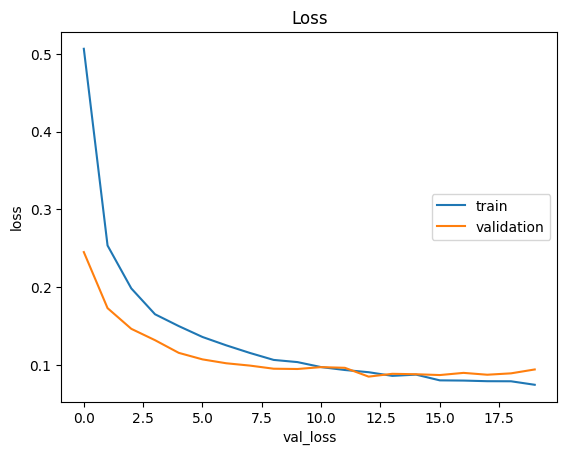

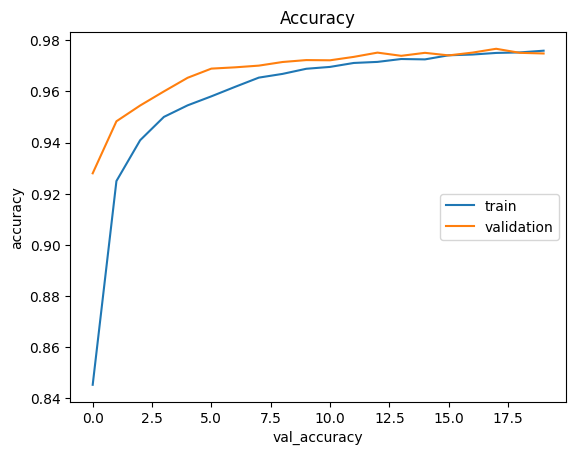

In [45]:
# Evaluate Model
eval_plot(model.history, ['loss', 'val_loss'], 'Loss')
eval_plot(model.history, ['accuracy', 'val_accuracy'], 'Accuracy')

In [46]:
# Test Model
test_scores = model.evaluate(x_test, y_test)
print('Test Loss: ', test_scores[0])
print('Test accuracy: ', test_scores[1] * 100)

313/313 [==============================] - 1s 3ms/step - loss: 0.0934 - accuracy: 0.9750
Test Loss:  0.09335249662399292
Test accuracy:  97.50000238418579
